# Quantifying Retail Panic Buying using Mobile Device Data
By Tom Weinandy, Data Scientist at [BlueGranite](https://www.blue-granite.com/about).

* This notebook is a demo associated with my [blog post](https://wwww.blue-granite.com/blog/quantifying-retail-panic-buying-using-mobile-device-data) of the same name. Check it out!
* The notebook requires data from [SafeGraph](https://www.safegraph.com/). I do noe have permission to share the csv files I use; however, a quick internet search will review some discount codes to try your own sample.
* For those using their own downloaded data, I included the #edit comment where you will have to make your own edits.

In [1]:
# Import packages and show current working directory
import pandas as pd, numpy as np, csv, os, datetime, random
from matplotlib import pyplot as plt
os.getcwd()

'c:\\Users\\ThomasWeinandy\\OneDrive - BlueGranite, Inc\\Demos\\foot_traffic'

## Add SafeGraph data

In [2]:
# Import foot traffic data (by length)
fileDate = ['jan', 'feb', 'mar']  #edit

firstFile = 'costco_traffic_' + fileDate[0] + '.csv'  #edit
ft = pd.read_csv(firstFile, dtype={'postal_code': object, 'visits_by_day': str}, encoding = 'unicode_escape')

for indx in range(1,3):
    path = 'costco_traffic_' + fileDate[indx] + '.csv' #edit
    moreData = pd.read_csv(path, dtype={'postal_code': object, 'visits_by_day': str}, encoding = 'unicode_escape')
    print('There are {} rows in "ft" and {} more being added to it.'.format(len(ft), len(moreData)))
    ft = ft.append(moreData)
    del moreData

# Remove stores where foot traffic data is na
ft = ft.dropna(subset=['visits_by_day']).copy()
ft = ft.reset_index(drop=True)

There are 531 rows in "ft" and 531 more being added to it.
There are 1062 rows in "ft" and 544 more being added to it.


In [3]:
# Clean up the dataset

# Drop unused columns and rename others
print('There are {} columns and {} rows in the foot traffic dataset.'.format(len(ft.columns), len(ft)))

columnsKept = ['safegraph_place_id', 'street_address', 'city', 'region', 'date_range_start', 'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand']

ft = ft[columnsKept].copy()
ft = ft.rename(columns = {'safegraph_place_id':'id', 'region':'state'})

# Remove stores without foot traffic data
dropThese = [i for i in range(len(ft)) if type(ft.iloc[i]['visits_by_day'])==float]
print('{} of the stores ({}%) were dropped for not having foot traffic data.'\
    .format(len(dropThese), round(len(dropThese)/len(ft)*100,2)))

ft = ft.drop(index = dropThese)
ft = ft.reset_index(drop=True)

# Create some new variables
ft['visits_per_visitor'] = ft['raw_visit_counts']/ft['raw_visitor_counts']

# Split bucketed dwell times and convert to stringed list
bucketedStrList = []
for b in range(len(ft)):
    buck = ft.loc[b,'bucketed_dwell_times'].replace('}','')
    bucket = buck.split(',')
    bucketedList = []
    for B in bucket:
        bucketed = int(B.split(':')[1])
        bucketedList.append(bucketed)   
    bucketedStrList.append(str(bucketedList))
ft['bucketed_dwell_times'] = bucketedStrList
print(ft.columns)

columnsDropped = ['street_address','raw_visit_counts','raw_visitor_counts']
ft = ft.drop(columns=columnsDropped)

# Remove stores without all months of data
store_datasets = ft.groupby('id')['visits_by_day'].count()
incomplete_stores = []
for indx in list(store_datasets.index):
    if store_datasets.loc[indx] != 3:       #edit for the number of months in your data
        incomplete_stores.append(indx)

ft = ft[~ft.id.isin(incomplete_stores)]
ft = ft.reset_index(drop=True)

print('Done. Now there are {} columns and {} rows left in the dataset.'.format(len(ft.columns), len(ft)))

There are 34 columns and 1573 rows in the foot traffic dataset.
0 of the stores (0.0%) were dropped for not having foot traffic data.
Index(['id', 'street_address', 'city', 'state', 'date_range_start',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'distance_from_home', 'median_dwell', 'bucketed_dwell_times',
       'related_same_day_brand', 'visits_per_visitor'],
      dtype='object')
Done. Now there are 10 columns and 1560 rows left in the dataset.


In [4]:
ft.head()

,id,city,state,date_range_start,visits_by_day,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,visits_per_visitor
0,sg:abbc26d77fee4baeaa2f1f4000aa903d,Littleton,CO,1.577837e+09,"[3,313,313,327,333,261,217,211,225,315,390,320...",8745.0,24.0,"[118, 2815, 3569, 665, 246]","{""King Soopers"":9}",1.556699
1,sg:73cc4999cd4f457d9b847db8298367d4,Burbank,CA,1.577837e+09,"[9,269,311,276,294,245,212,256,247,265,289,315...",6772.0,26.0,"[133, 2471, 3377, 848, 276]",{},1.544565
2,sg:221d74b4871948bd8d671966456786b6,Prescott,AZ,1.577837e+09,"[0,289,263,244,190,205,174,209,195,231,263,186...",12392.0,26.0,"[87, 2145, 2734, 681, 228]","{""PetSmart"":12,""Walmart"":6}",1.687733
3,sg:24cdb44c50ae42c38b4609f0dd5078d4,Schaumburg,IL,1.577837e+09,"[4,267,257,317,265,210,187,228,178,244,248,249...",7471.0,20.0,"[175, 3145, 2487, 449, 118]","{""IKEA"":10,""Sears"":6}",1.495542
4,sg:576807f55a4242ce9db47c85f20ff121,Stafford Township,NJ,1.577837e+09,"[0,106,122,160,162,91,98,91,83,95,191,159,83,6...",14499.0,24.0,"[38, 1248, 1354, 342, 170]","{""Wawa"":9,""Five Below"":8,""Kohl's"":7,""T.J. Maxx...",1.608984


# Bring in COVID Data
COVID-19 data comes from [usafacts.org](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/)

In [5]:
# Import dataframe and reduce variables

deaths_post_covid_df = ( pd.read_csv('covid_deaths_usafacts.csv')
            .drop(columns=['County Name', 'stateFIPS', 'countyFIPS'])
            .groupby('State')
            .sum()
            .iloc[:,:70] )                                             # removes dates past 3/31/20 #edit if using different time frame

cases_post_covid_df = ( pd.read_csv('covid_confirmed_usafacts.csv')
            .drop(columns=['County Name', 'stateFIPS', 'countyFIPS'])
            .groupby('State')
            .sum()
            .iloc[:,:70] )                                                                          #edit if using different time frame

In [6]:
cases_post_covid_df.sort_values(by='3/31/20', ascending=False).head(10)           # See the highest-impacted states at the end of March #edit

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
State,,,,,,,,,,,,,,,,,,,,,
NY,0,0,0,0,0,0,0,0,0,0,...,15832,20909,25578,32968,38976,44813,53303,59240,67194,74447
NJ,0,0,0,0,0,0,0,0,0,0,...,1914,2851,3675,4402,6331,8825,10836,13386,16636,18696
CA,0,0,0,0,2,3,3,4,4,4,...,2105,2587,2990,3518,4368,5226,6058,6707,7643,8815
MI,0,0,0,0,0,0,0,0,0,0,...,1037,1327,1789,2292,2855,3656,4650,5465,6495,7613
FL,0,0,0,0,0,0,0,0,0,0,...,1005,1227,1412,1975,2458,3198,4038,4948,5704,6741
MA,0,0,0,0,0,0,0,0,0,0,...,645,776,1157,1835,2414,3240,4257,4851,5752,6620
IL,0,0,1,1,1,1,1,1,1,2,...,1049,1285,1536,1864,2540,3027,3491,4596,5057,5993
WA,1,1,1,1,1,1,1,1,1,1,...,1996,2221,2455,2581,3206,3758,4289,4896,5414,5662
LA,0,0,0,0,0,0,0,0,0,0,...,837,1163,1384,1795,2303,2743,3313,3537,4023,5235


# Fill out dateframe, calculate rolling average

In [7]:
state_list = list(cases_post_covid_df.index)

# Create pre-COVID data (just zeroes)
first_day = datetime.datetime(2019,12,26)                                           # Early days required to calculate 7-day average #edit?
date_list_pre = [first_day + datetime.timedelta(days=x) for x in range(27)]         # pre-COVID days are from Jan 1 to 21 (plus 6 days) #edit?
date_list_pre = [date.strftime('%#m/%#d/%y') for date in date_list_pre]             # NOTE: If using Linux, replace '#' with '-'

pre_covid_df = pd.DataFrame(0, index = state_list, columns=date_list_pre)

# Add pre-COVID data to cases, deaths dataframes
cases_df = ( pre_covid_df.merge(cases_post_covid_df, left_index=True, right_index=True)
                         .iloc[:,6:] )                                              # drop 6 days in 2019 used for later calculation #edit

deaths_df = ( pre_covid_df.merge(deaths_post_covid_df, left_index=True, right_index=True)                                              
                          .iloc[:,6:] )                                             

# Calculate 7-day rolling average
cases_rolling_df = ( pre_covid_df.merge(cases_post_covid_df, left_index=True, right_index=True)
                                 .rolling(7, axis=1)                                # 7-day window
                                 .mean()                                            # take that average
                                 .iloc[:,6:] )                                      # drop 6 days in 2019 used in calculation #edit

deaths_rolling_df = ( pre_covid_df.merge(deaths_post_covid_df, left_index=True, right_index=True)
                           .rolling(7, axis=1)                                      
                           .mean()                                                  
                           .iloc[:,6:] )                                              

In [8]:
# cases_rolling_df.head()

# Explode COVID data vertically

In [9]:
# Introduce population 
pop = ( pd.read_csv('covid_county_population_usafacts.csv')
          .drop(columns='countyFIPS')
          .groupby('State')
          .sum()
          .sort_values(by='population', ascending=False)
          .rename({'population': 'state_pop'}, axis='columns')
          )

In [10]:
# Define new dataframe & lists
covid_df = pd.DataFrame()
state_list = sorted(list(cases_df.index)) 
date_list = list(cases_df.columns)

# Add corresponding cases and deaths for post-COVID days
for state in state_list:
    state_pop_per100k = pop.loc[state][0]/100000

    for date in date_list:
        cases = [cases_df.loc[state, date]]
        deaths = [deaths_df.loc[state, date]]
        cases_7dayavg = [cases_rolling_df.loc[state, date]]
        deaths_7dayavg = [deaths_rolling_df.loc[state, date]]

        state_date = pd.DataFrame({'state': state, 'date': date, 
                                   'cases': cases, 'cases_per100k':cases/state_pop_per100k,
                                   'cases_7dayavg':cases_7dayavg, 'cases_7dayavg_per100k':cases_7dayavg/state_pop_per100k,
                                   'deaths': deaths, 'deaths_per100k':deaths/state_pop_per100k,
                                   'deaths_7dayavg':deaths_7dayavg, 'deaths_7dayavg_per100k': deaths_7dayavg/state_pop_per100k})
        covid_df = covid_df.append(state_date)

covid_df = covid_df.reset_index(drop=True)

In [11]:
# covid_df[covid_df['state']=='MI']

In [12]:
# covid_df.to_csv('covid_exploaded.csv', index=False)
# covid_df = pd.read_csv('covid_exploaded.csv')

# Explode SafeGraph data vertically

In [13]:
ft.head()

,id,city,state,date_range_start,visits_by_day,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,visits_per_visitor
0,sg:abbc26d77fee4baeaa2f1f4000aa903d,Littleton,CO,1.577837e+09,"[3,313,313,327,333,261,217,211,225,315,390,320...",8745.0,24.0,"[118, 2815, 3569, 665, 246]","{""King Soopers"":9}",1.556699
1,sg:73cc4999cd4f457d9b847db8298367d4,Burbank,CA,1.577837e+09,"[9,269,311,276,294,245,212,256,247,265,289,315...",6772.0,26.0,"[133, 2471, 3377, 848, 276]",{},1.544565
2,sg:221d74b4871948bd8d671966456786b6,Prescott,AZ,1.577837e+09,"[0,289,263,244,190,205,174,209,195,231,263,186...",12392.0,26.0,"[87, 2145, 2734, 681, 228]","{""PetSmart"":12,""Walmart"":6}",1.687733
3,sg:24cdb44c50ae42c38b4609f0dd5078d4,Schaumburg,IL,1.577837e+09,"[4,267,257,317,265,210,187,228,178,244,248,249...",7471.0,20.0,"[175, 3145, 2487, 449, 118]","{""IKEA"":10,""Sears"":6}",1.495542
4,sg:576807f55a4242ce9db47c85f20ff121,Stafford Township,NJ,1.577837e+09,"[0,106,122,160,162,91,98,91,83,95,191,159,83,6...",14499.0,24.0,"[38, 1248, 1354, 342, 170]","{""Wawa"":9,""Five Below"":8,""Kohl's"":7,""T.J. Maxx...",1.608984


In [14]:
# Define function to convert foot triffic from stringed list to list of integers
def no_strings_on_me(string):
    string = string.replace('[','').replace(']','').replace(';',',')
    string = string.split(',')
    string = [float(item) for item in string]
    return string

data_columns = ['id', 'date', 'city', 'state', 'visits', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times', 'visits_per_visitor']
data = pd.DataFrame(columns=data_columns)

In [15]:
# Makes each observation an individual store-day
#   (this part takes a while)

for i in range(len(ft)):
    if round(i/250) == i/250: # occasionally prints status, finishes at 1.0
        print(i/len(ft))
        
    visit_list = no_strings_on_me(ft.loc[i, 'visits_by_day'])

    unix = int(ft.loc[i, 'date_range_start'] + 5*60*60)                    # adds 6h (in seconds) for the time zone adjustment
    first_day = datetime.datetime.fromtimestamp(unix)
    date_list = [first_day + datetime.timedelta(days=x) for x in range(len(visit_list))] 
    date_list = [date.strftime('%#m/%#d/%y') for date in date_list]
    
    # Loops through each day of the visit, makes it a series, appends to other series, adds to dataframe
    for v in range(len(visit_list)):
        add_df = pd.DataFrame({'id': ft.loc[i, 'id'],
                            'date': date_list[v],
                            'visits': visit_list[v],
                            'city': ft.loc[i, 'city'],
                            'state': ft.loc[i, 'state'],
                            'visits': visit_list[v],
                            'distance_from_home': ft.loc[i, 'distance_from_home'],
                            'median_dwell': ft.loc[i, 'median_dwell'],
                            'bucketed_dwell_times': ft.loc[i, 'bucketed_dwell_times'],
                            'visits_per_visitor': ft.loc[i, 'visits_per_visitor']
                            },
                            index = [i]
                            )
        data = data.append(add_df)
        
data = data.reset_index(drop=True)

0.0
0.16025641025641027
0.32051282051282054
0.4807692307692308
0.6410256410256411
0.8012820512820513
0.9615384615384616


In [16]:
# data.head()

# Merge SafeGraph and COVID data

In [17]:
data = data.merge(covid_df, on=['state', 'date'], how='left') #.drop(columns=['date_range_start', 'visits_by_day'])
# data

# Add time variables to foot traffic data

In [18]:
# Add day of week as dummy variables
data.insert(2,'weekday', data['date'])
for i in range(len(data)):                            # converts from string date to a string day of week
    data.loc[i, 'weekday'] = datetime.datetime.strptime(data.loc[i, 'weekday'], '%m/%d/%y').strftime('%a')

In [19]:
# Drop new year's day, two stores that appear to be closed and obvs without COVID data
data = data[~data.id.isin(['sg:c8b095554b7e43d2a4a60e27907246bc', '2e1bdf6e0618460e90028bd38dc23571'])]   #edit
data = data[~data.date.isin(['1/1/20'])]                                                                  #edit 
data = data.dropna(subset=['cases'])

In [20]:
# data.to_csv('covid_visits.csv', index=False)
# data = pd.read_csv('covid_visits.csv')
data = data.set_index(['id', 'date'])
data

weekday       city state  visits  \
id                                  date                                       
sg:abbc26d77fee4baeaa2f1f4000aa903d 1/2/20      Thu  Littleton    CO   313.0   
                                    1/3/20      Fri  Littleton    CO   313.0   
                                    1/4/20      Sat  Littleton    CO   327.0   
                                    1/5/20      Sun  Littleton    CO   333.0   
                                    1/6/20      Mon  Littleton    CO   261.0   
...                                             ...        ...   ...     ...   
sg:909627fb22a94bd98d848855f90b59e8 3/27/20     Fri    Orlando    FL    53.0   
                                    3/28/20     Sat    Orlando    FL    50.0   
                                    3/29/20     Sun    Orlando    FL     0.0   
                                    3/30/20     Mon    Orlando    FL    54.0   
                                    3/31/20     Tue    Orlando    FL    40.0   

                                             distance_from_home  median_dwell  \
id                                  date                                        
sg:abbc26d77fee4baeaa2f1f4000aa903d 1/2/20               8745.0          24.0   
                                    1/3/20               8745.0          24.0   
                                    1/4/20               8745.0          24.0   
                                    1/5/20               8745.0          24.0   
                                    1/6/20               8745.0          24.0   
...                                                         ...           ...   
sg:909627fb22a94bd98d848855f90b59e8 3/27/20             11393.0          21.0   
                                    3/28/20             11393.0          21.0   
                                    3/29/20             11393.0          21.0   
                                    3/30/20             11393.0          21.0   
                                    3/31/20             11393.0          21.0   

                                                    bucketed_dwell_times  \
id                                  date                                   
sg:abbc26d77fee4baeaa2f1f4000aa903d 1/2/20   [118, 2815, 3569, 665, 246]   
                                    1/3/20   [118, 2815, 3569, 665, 246]   
                                    1/4/20   [118, 2815, 3569, 665, 246]   
                                    1/5/20   [118, 2815, 3569, 665, 246]   
                                    1/6/20   [118, 2815, 3569, 665, 246]   
...                                                                  ...   
sg:909627fb22a94bd98d848855f90b59e8 3/27/20     [53, 1060, 918, 161, 97]   
                                    3/28/20     [53, 1060, 918, 161, 97]   
                                    3/29/20     [53, 1060, 918, 161, 97]   
                                    3/30/20     [53, 1060, 918, 161, 97]   
                                    3/31/20     [53, 1060, 918, 161, 97]   

                                             visits_per_visitor   cases  \
id                                  date                                  
sg:abbc26d77fee4baeaa2f1f4000aa903d 1/2/20             1.556699     0.0   
                                    1/3/20             1.556699     0.0   
                                    1/4/20             1.556699     0.0   
                                    1/5/20             1.556699     0.0   
                                    1/6/20             1.556699     0.0   
...                                                         ...     ...   
sg:909627fb22a94bd98d848855f90b59e8 3/27/20            1.606316  3198.0   
                                    3/28/20            1.606316  4038.0   
                                    3/29/20            1.606316  4948.0   
                                    3/30/20            1.606316  5704.0   
                                    3/31/20            1.606

# Create descriptive stats for foot traffic groupings

In [21]:
# Show foot traffic by day of week
blue_meanies = data.groupby(['weekday'])['visits'].mean()
# blue_meanies.sort_values()

# Center foot traffic data
Data is centered with data from to January and February, before the pandemic was widely realized to be in the US.

Text(0.5, 1.0, 'Weekly Visit Patterns to Costco')

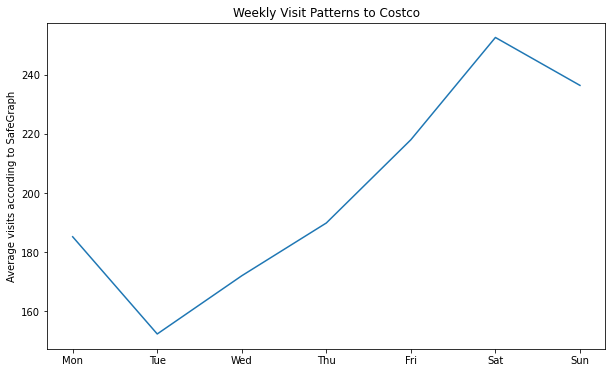

In [22]:
# Show why it is important to correct for weekly seasonality

from matplotlib import pyplot as plt

dfc = data.reset_index()
dfc_weekly = ( dfc.groupby('weekday')
                  .mean()['visits']
                  .reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']) ) 

# Create figure, set size
fig = plt.figure(1, figsize=(10,6))
plt.plot(dfc_weekly)

plt.ylabel('Average visits according to SafeGraph')
plt.title('Weekly Visit Patterns to Costco')

In [23]:
# Center visits
   # Create variable 'dev' as the deviation from the average visits (pre-COVID) that a store gets on that day of week
   #  and 'stdev' as dev divided by the standard deviation.
dfc = data.reset_index()
dfc.insert(6, 'visits_dev', '')
dfc.insert(7, 'visits_stdev', '')

store_list = list(dfc['id'].unique())
day_list = list(dfc['weekday'].unique())
date_list = list(dfc['date'].unique())
date_list_precovid = date_list[:-31]      # Removes the month of March #edit

dfc_precovid = dfc[dfc['date'].isin(date_list_precovid)]
dfc_precovid_group_mean = dfc_precovid.groupby(['id', 'weekday']).mean()
dfc_precovid_group_stdev = dfc_precovid.groupby(['id', 'weekday']).std()

dfc = dfc.set_index(['id','date'])

for store in store_list:
    for date in date_list:
        a_date = dfc['visits'].loc[store, date]
        day_of_week = dfc.loc[store, date]['weekday']
        day_of_week_mean = dfc_precovid_group_mean.loc[store, day_of_week][0]
        day_of_week_stdev = dfc_precovid_group_stdev.loc[store, day_of_week][0]
        
        dfc.loc[(store, date), 'visits_dev'] = a_date - day_of_week_mean
        dfc.loc[(store, date), 'visits_stdev'] = (a_date - day_of_week_mean)/day_of_week_stdev

dfc = dfc.reset_index()

# Plot SafeGraph and COVID data together

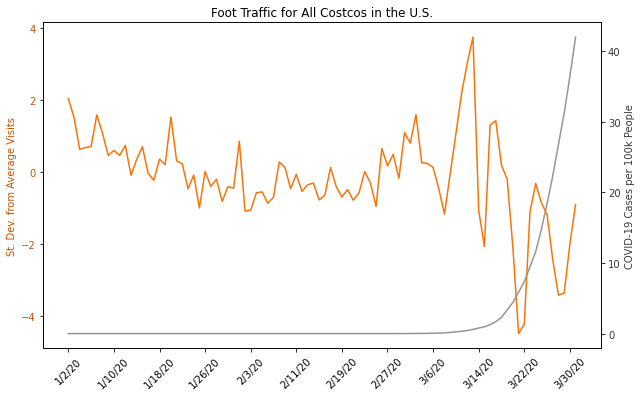

In [24]:
# Plot the average foot traffic at Costco and compare against national COVID cases
from matplotlib import pyplot as plt

# Select store and measures (print dfc.columns to see options)
id = random.choice(store_list)        # selects a random store from list
visit_measure = 'visits_stdev'        # choose between 'visits', 'visits_dev' or 'visits_stdev'
covid_measure = 'cases_per100k'       # choose between 'cases' or 'cases_per100k'

# Convert 'date' column from str to datetime
dfc['Date'] =  pd.to_datetime(dfc['date'], format='%m/%d/%y')
dfc['visits_dev'] = pd.to_numeric(dfc['visits_dev'])
dfc['visits_stdev'] = pd.to_numeric(dfc['visits_stdev'])
covid_df['Date'] =  pd.to_datetime(covid_df['date'], format='%m/%d/%y')

# Define time series
ts = dfc[dfc['id']==id]
data1 = dfc.groupby('Date').mean()[visit_measure]
data2 = covid_df.groupby('Date').sum()[covid_measure][1:]/51  # Drops 1/1/20 so the two series have the same time frame

# Create figure, set size
fig = plt.figure(1, figsize=(10,6))

# Add first plot on figure, format LHS y-axis
ax1 = fig.add_subplot(111)
color1 = 'xkcd:orange'
color2 = 'xkcd:dark orange'
ax1.set_ylabel('St. Dev. from Average Visits', color=color2)
ax1.plot(ts['date'], data1, color=color1)
ax1.tick_params(axis='y', labelcolor=color2)

# Add second plot on figure, format RHS y-axis
ax2 = ax1.twinx()  
color3 = 'xkcd:grey'
color4 = 'xkcd:dark grey'
ax2.set_ylabel('COVID-19 Cases per 100k People', color=color4)
ax2.plot(ts['date'], data2, color=color3)
ax2.tick_params(axis='y', labelcolor=color4)

# Format x-axis
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(plt.MaxNLocator(13)) # sets the number of tick marks

# Format title
title_text = 'Foot Traffic for All Costcos in the U.S.'
plt.title(title_text)
plt.show()

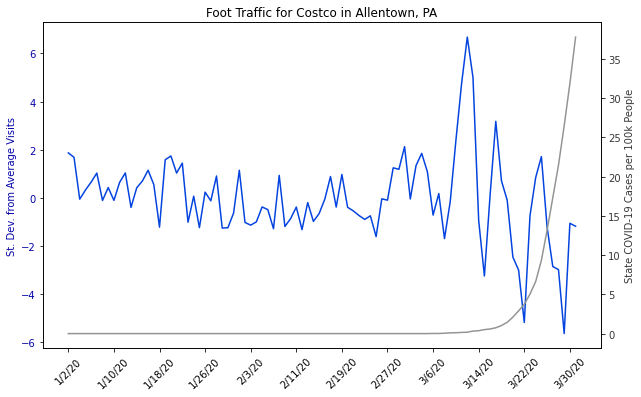

In [25]:
# Plot a random store's foot traffic and compare against state COVID cases
from matplotlib import pyplot as plt

# Select store and measures (print dfc.columns to see options)
id = random.choice(store_list) # selects a random store from list
# id = 'sg:1b8c23a441a640248367643f963033aa' # Kalamazoo                         # A few good examples of grpahs
# id = 'sg:4dab959813ba42b58e704039bf756bad' # Morrow, GA (big swings)
# id = 'sg:6eed868a9aa143c6995769b6ecd03a99' # Colchester, VT (minor change)
# id = 'sg:271706f7ccc04e5b82cf9a934ff90f90' # Clovis, CA (down-ward shift)
# id = 'sg:76279adebf14402fa74ac2261b02adb1' # Newport News, VA (good example)
visit_measure = 'visits_stdev'
covid_measure = 'cases_per100k'

# Define time series
ts = dfc[dfc['id']==id]                                  
data1 = ts[['date', visit_measure]].set_index('date')
data2 = ts[['date', covid_measure]].set_index('date')
data3 = covid_df.groupby('Date').sum()[covid_measure][1:]/51

# Create figure, set size
fig = plt.figure(1, figsize=(10,6))

# Add first plot on figure, format LHS y-axis
ax1 = fig.add_subplot(111)
color1 = 'xkcd:blue'
color2 = 'xkcd:royal blue'
ax1.set_ylabel('St. Dev. from Average Visits', color=color2)
ax1.plot(ts['date'], data1, color=color1)
ax1.tick_params(axis='y', labelcolor=color2)

# # Add third plot on figure, format RHS y-axis (National Average)
# ax2 = ax1.twinx()  
# color4 = 'tab:orange'
# ax2.set_ylabel(covid_measure, color=color4)
# ax2.plot(ts['date'], data3, color=color4)
# ax2.tick_params(axis='y', labelcolor='xkcd:orange')

# Add second plot on figure, format RHS y-axis
ax2 = ax1.twinx()
color3 = 'xkcd:grey'
color4 = 'xkcd:dark grey'
ax2.set_ylabel('State COVID-19 Cases per 100k People', color=color4)
ax2.plot(ts['date'], data2, color=color3)
ax2.tick_params(axis='y', labelcolor=color4)

# Format x-axis
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(plt.MaxNLocator(14)) # sets the number of tick marks

# Format title
title_text = 'Foot Traffic for Costco in ' + np.unique(ts['city'])[0] + ', ' + np.unique(ts['state'])[0]
plt.title(title_text)
plt.show()

In [26]:
# np.unique(dfc[dfc['city']=='Austin'][['id', 'city']])

# Print histograms for each column

In [27]:
print('Unfreeze the below cell to print histograms. Careful, there are {} of them.'.format(len(dfc.columns)))
dfc.columns

Unfreeze the below cell to print histograms. Careful, there are 21 of them.


Index(['id', 'date', 'weekday', 'city', 'state', 'visits', 'visits_dev',
       'visits_stdev', 'distance_from_home', 'median_dwell',
       'bucketed_dwell_times', 'visits_per_visitor', 'cases', 'cases_per100k',
       'cases_7dayavg', 'cases_7dayavg_per100k', 'deaths', 'deaths_per100k',
       'deaths_7dayavg', 'deaths_7dayavg_per100k', 'Date'],
      dtype='object')

In [28]:
dfc.head()

,id,date,weekday,city,state,visits,visits_dev,visits_stdev,distance_from_home,median_dwell,...,visits_per_visitor,cases,cases_per100k,cases_7dayavg,cases_7dayavg_per100k,deaths,deaths_per100k,deaths_7dayavg,deaths_7dayavg_per100k,Date
0,sg:abbc26d77fee4baeaa2f1f4000aa903d,1/2/20,Thu,Littleton,CO,313.0,93.333333,2.061137,8745.0,24.0,...,1.556699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-02
1,sg:abbc26d77fee4baeaa2f1f4000aa903d,1/3/20,Fri,Littleton,CO,313.0,61.777778,1.147443,8745.0,24.0,...,1.556699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-03
2,sg:abbc26d77fee4baeaa2f1f4000aa903d,1/4/20,Sat,Littleton,CO,327.0,-10.444444,-0.339933,8745.0,24.0,...,1.556699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-04
3,sg:abbc26d77fee4baeaa2f1f4000aa903d,1/5/20,Sun,Littleton,CO,333.0,52.375000,1.317763,8745.0,24.0,...,1.556699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-05
4,sg:abbc26d77fee4baeaa2f1f4000aa903d,1/6/20,Mon,Littleton,CO,261.0,62.750000,1.253729,8745.0,24.0,...,1.556699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-06


--- Cannot print graph for id becuase it is a string
--- Cannot print graph for date becuase it is a string
--- Cannot print graph for weekday becuase it is a string
--- Cannot print graph for city becuase it is a string
--- Cannot print graph for state becuase it is a string
Show graphs for visits


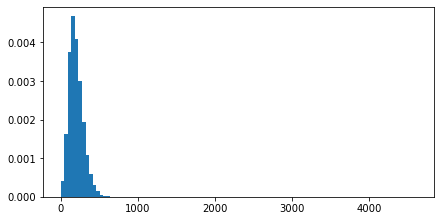

...and zoom in on the inner 95%.


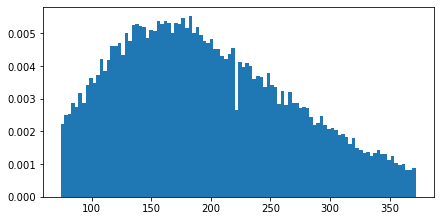

Show graphs for visits_dev


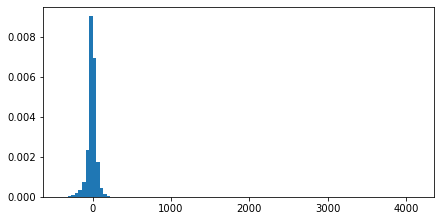

...and zoom in on the inner 95%.


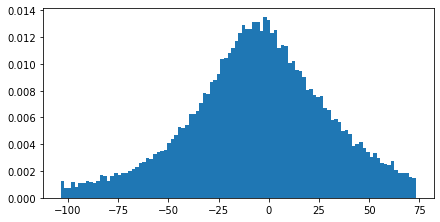

Show graphs for visits_stdev


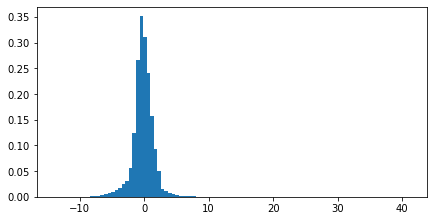

...and zoom in on the inner 95%.


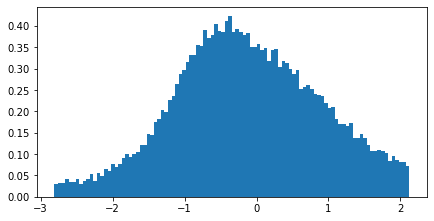

Show graphs for distance_from_home


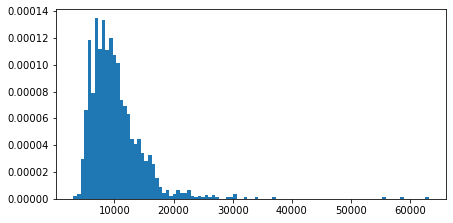

...and zoom in on the inner 95%.


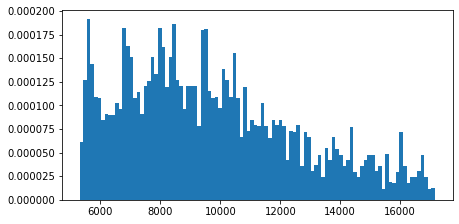

Show graphs for median_dwell


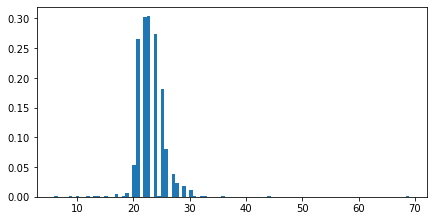

...and zoom in on the inner 95%.


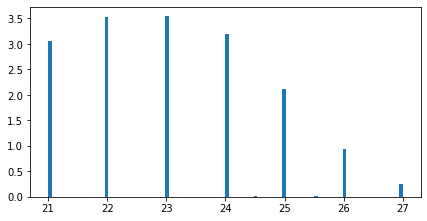

--- Cannot print graph for bucketed_dwell_times becuase it is a string
Show graphs for visits_per_visitor


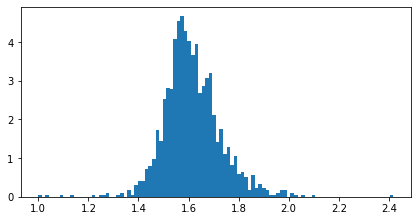

...and zoom in on the inner 95%.


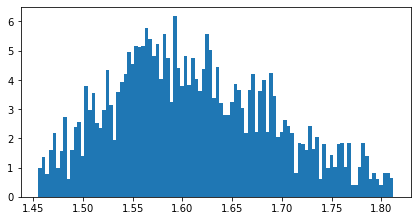

Show graphs for cases


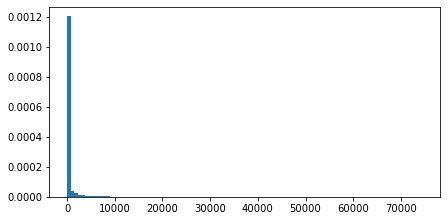

...and zoom in on the inner 95%.


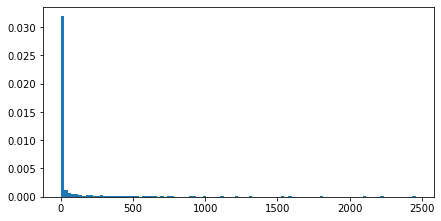

Show graphs for cases_per100k


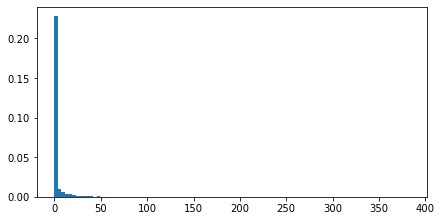

...and zoom in on the inner 95%.


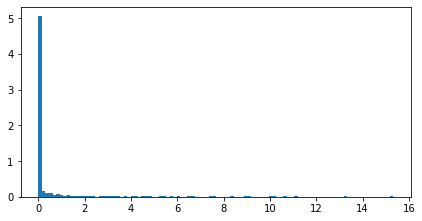

Show graphs for cases_7dayavg


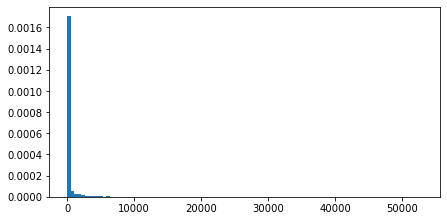

...and zoom in on the inner 95%.


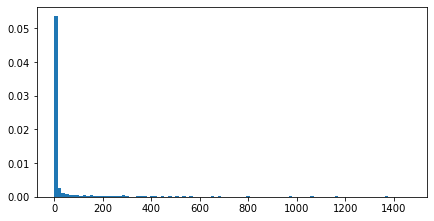

Show graphs for cases_7dayavg_per100k


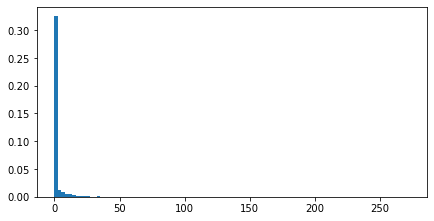

...and zoom in on the inner 95%.


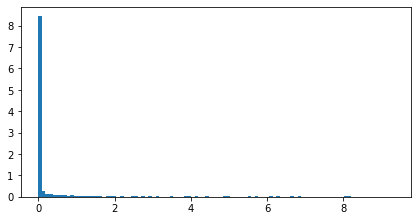

Show graphs for deaths


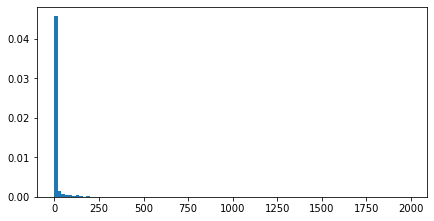

...and zoom in on the inner 95%.


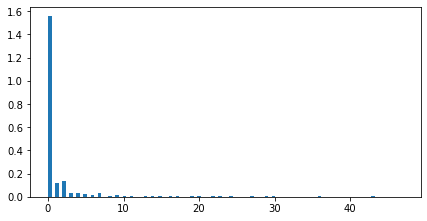

Show graphs for deaths_per100k


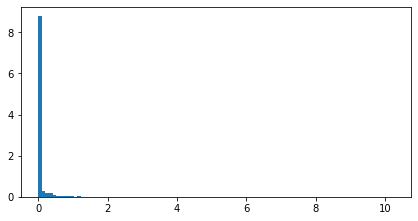

...and zoom in on the inner 95%.


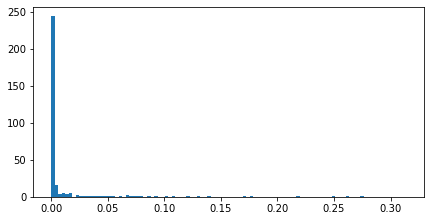

Show graphs for deaths_7dayavg


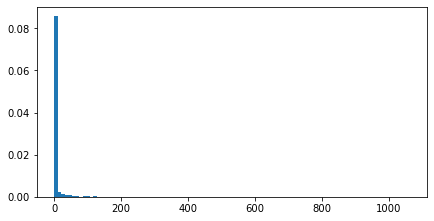

...and zoom in on the inner 95%.


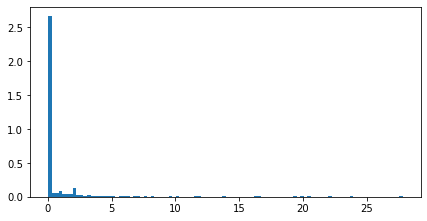

Show graphs for deaths_7dayavg_per100k


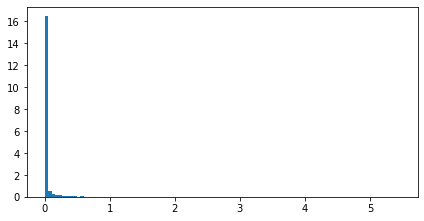

...and zoom in on the inner 95%.


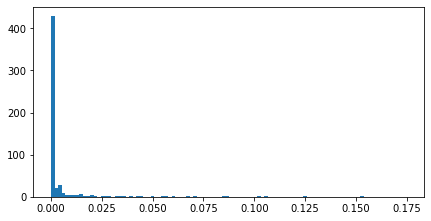

Show graphs for Date


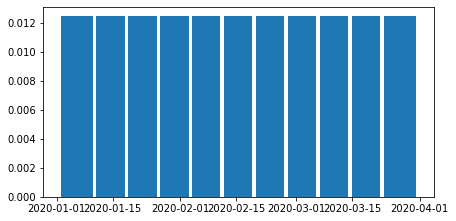

...and zoom in on the inner 95%.


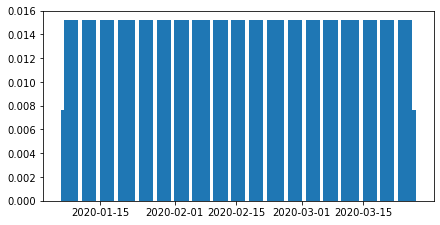

In [29]:
# Plot the store-day tweet data to see how it changed with the standardization process

n = 0.05
N = round(len(dfc)*n)
for c in dfc.columns:
    try:
        if type(dfc.loc[0,c]) != str:
            print('Show graphs for {}'.format(c))
            x = dfc.sort_values(by = c)[c]
            plt.figure(figsize=(7,3.5))
            plt.hist(x, density=True, bins = 100)
            plt.show()

            print('...and zoom in on the inner {}%.'.format(int(round(1-n,2)*100)))
            x = dfc.sort_values(by = c)[c][N:-N]
            plt.figure(figsize=(7,3.5))
            plt.hist(x, density=True, bins = 100)
            plt.show()
        else:
            print('--- Cannot print graph for {} becuase it is a string'.format(c))
    except:
        print('--- No graphs printed for {}'.format(c))

# Coscto foot traffic (national) with COVID-19 data

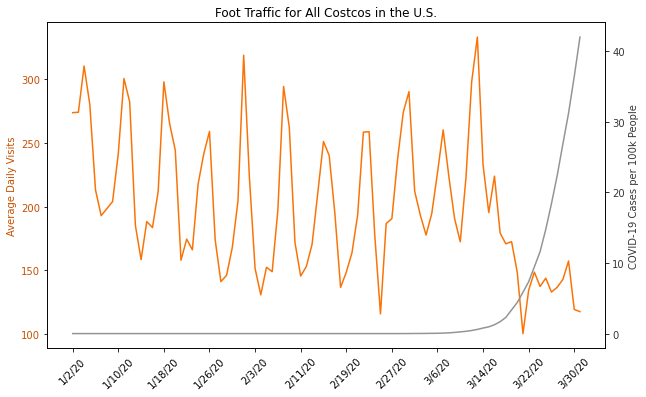

In [30]:
# 1. Show Costco national with COVID data

# Select store and measures (print dfc.columns to see options)
id = random.choice(store_list) # selects a random store from list
visit_measure = 'visits'                                                   # Can use 'visits', 'visits_dev' or 'visits_stdev'
covid_measure = 'cases_per100k'                                            # Can use 'cases' or 'cases_per100k'

# # Convert 'date' column from str to datetime
# dfc['Date'] =  pd.to_datetime(dfc['date'], format='%m/%d/%y')
# dfc['visits_dev'] = pd.to_numeric(dfc['visits_dev'])
# dfc['visits_stdev'] = pd.to_numeric(dfc['visits_stdev'])
# covid_df['Date'] =  pd.to_datetime(covid_df['date'], format='%m/%d/%y')

# Define time series
ts = dfc[dfc['id']==id]
data1 = dfc.groupby('Date').mean()[visit_measure]
data2 = covid_df.groupby('Date').sum()[covid_measure][1:]/51  # Drops 1/1/20 so the two series have the same time frame #edit

# Create figure, set size
fig = plt.figure(1, figsize=(10,6))

# Add first plot on figure, format LHS y-axis
ax1 = fig.add_subplot(111)
color1 = 'xkcd:orange'
color2 = 'xkcd:dark orange'
ax1.set_ylabel('Average Daily Visits', color=color2)
ax1.plot(ts['date'], data1, color=color1)
ax1.tick_params(axis='y', labelcolor=color2)

# Add second plot on figure, format RHS y-axis
ax2 = ax1.twinx()  
color3 = 'xkcd:grey'
color4 = 'xkcd:dark grey'
ax2.set_ylabel('COVID-19 Cases per 100k People', color=color4)
ax2.plot(ts['date'], data2, color=color3)
ax2.tick_params(axis='y', labelcolor=color4)

# Format x-axis
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(plt.MaxNLocator(13)) # sets the number of tick marks

# Format title
title_text = 'Foot Traffic for All Costcos in the U.S.'
plt.title(title_text)
plt.show()

# Store visits by day of week

Text(0.5, 1.0, 'Weekly Visit Patterns to Costco')

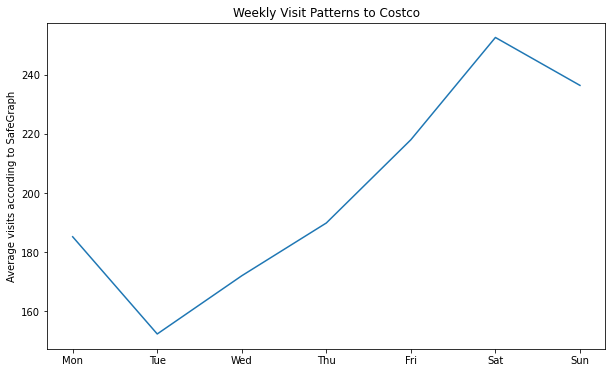

In [31]:
# 2. Show visits by day of the week
dfc_weekly = ( data.reset_index()
                  .groupby('weekday')
                  .mean()['visits']
                  .reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']) ) 

# Create figure, set size
fig = plt.figure(1, figsize=(10,6))
plt.plot(dfc_weekly)

plt.ylabel('Average visits according to SafeGraph')
plt.title('Weekly Visit Patterns to Costco') 

# Distribution of visits

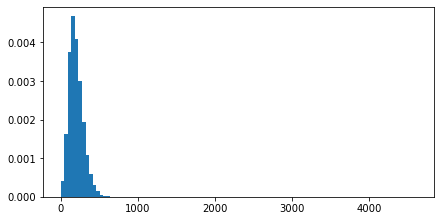

In [32]:
# 3. Show distribution of visits
n = 0.005
N = round(len(dfc)*n)

x = dfc.sort_values(by = 'visits')['visits'] #[N:-N]
plt.figure(figsize=(7,3.5))
plt.hist(x, density=True, bins = 100)
plt.show()

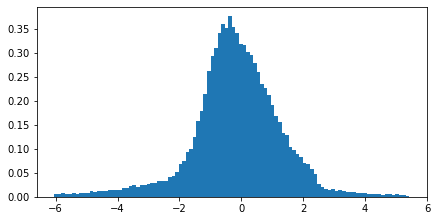

In [33]:
# 4. Show distribution of standard deviation
x = dfc.sort_values(by = 'visits_stdev')['visits_stdev'][N:-N]
plt.figure(figsize=(7,3.5))
plt.hist(x, density=True, bins = 100)
plt.show()

# Costco foot traffic in standard deviations

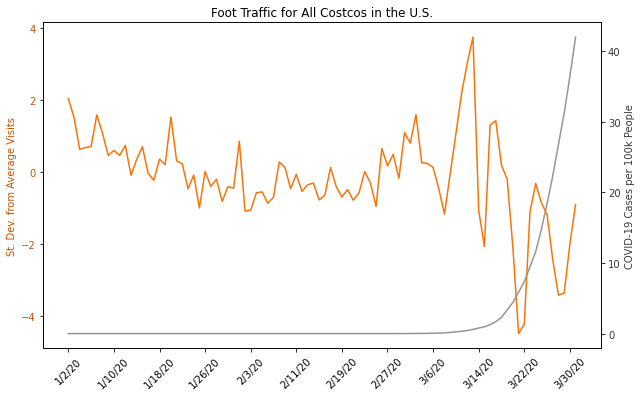

In [34]:
# 5. Show national sds 

# Select store and measures (print dfc.columns to see options)
id = random.choice(store_list) # selects a random store from list
visit_measure = 'visits_stdev'                                                   # Can use 'visits', 'visits_dev' or 'visits_stdev'
covid_measure = 'cases_per100k'                                            # Can use 'cases' or 'cases_per100k'

# Define time series
ts = dfc[dfc['id']==id]
data1 = dfc.groupby('Date').mean()[visit_measure]
data2 = covid_df.groupby('Date').sum()[covid_measure][1:]/51  # Drops 1/1/20 so the two series have the same time frame #edit

# Create figure, set size
fig = plt.figure(1, figsize=(10,6))

# Add first plot on figure, format LHS y-axis
ax1 = fig.add_subplot(111)
color1 = 'xkcd:orange'
color2 = 'xkcd:dark orange'
ax1.set_ylabel('St. Dev. from Average Visits', color=color2)
ax1.plot(ts['date'], data1, color=color1)
ax1.tick_params(axis='y', labelcolor=color2)

# Add second plot on figure, format RHS y-axis
ax2 = ax1.twinx()  
color3 = 'xkcd:grey'
color4 = 'xkcd:dark grey'
ax2.set_ylabel('COVID-19 Cases per 100k People', color=color4)
ax2.plot(ts['date'], data2, color=color3)
ax2.tick_params(axis='y', labelcolor=color4)

# Format x-axis
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(plt.MaxNLocator(13)) # sets the number of tick marks

# Format title
title_text = 'Foot Traffic for All Costcos in the U.S.'
plt.title(title_text)
plt.show()


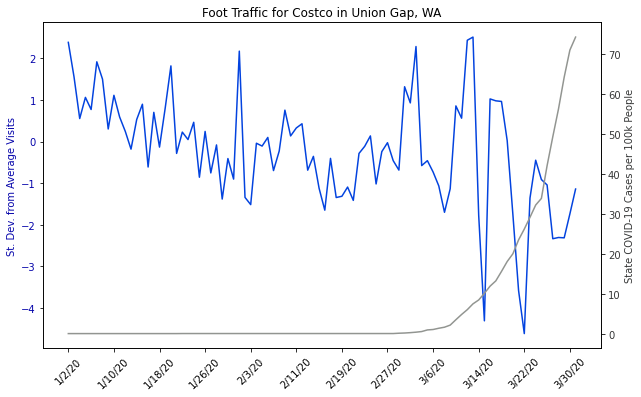

In [35]:
# 6. Show random store sds

# Select store and measures (print dfc.columns to see options)
id = random.choice(store_list) # selects a random store from list
# id = 'sg:1b8c23a441a640248367643f963033aa' # Kalamazoo
# id = 'sg:4dab959813ba42b58e704039bf756bad' # Morrow, GA (big swings)
# id = 'sg:6eed868a9aa143c6995769b6ecd03a99' # Colchester, VT (minor change)
# id = 'sg:271706f7ccc04e5b82cf9a934ff90f90' # Clovis, CA (down-ward shift)
# id = 'sg:76279adebf14402fa74ac2261b02adb1' # Newport News, VA (good example)
visit_measure = 'visits_stdev'
covid_measure = 'cases_per100k'

# Define time series
ts = dfc[dfc['id']==id]                                  
data1 = ts[['date', visit_measure]].set_index('date')
data2 = ts[['date', covid_measure]].set_index('date')
data3 = covid_df.groupby('Date').sum()[covid_measure][1:]/51

# Create figure, set size
fig = plt.figure(1, figsize=(10,6))

# Add first plot on figure, format LHS y-axis
ax1 = fig.add_subplot(111)
color1 = 'xkcd:blue'
color2 = 'xkcd:royal blue'
ax1.set_ylabel('St. Dev. from Average Visits', color=color2)
ax1.plot(ts['date'], data1, color=color1)
ax1.tick_params(axis='y', labelcolor=color2)

# Add second plot on figure, format RHS y-axis
ax2 = ax1.twinx()
color3 = 'xkcd:grey'
color4 = 'xkcd:dark grey'
ax2.set_ylabel('State COVID-19 Cases per 100k People', color=color4)
ax2.plot(ts['date'], data2, color=color3)
ax2.tick_params(axis='y', labelcolor=color4)

# Format x-axis
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(plt.MaxNLocator(14)) # sets the number of tick marks

# Format title
title_text = 'Foot Traffic for Costco in ' + np.unique(ts['city'])[0] + ', ' + np.unique(ts['state'])[0]
plt.title(title_text)
plt.show()